In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import pandas as pd

In [30]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [32]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [33]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [34]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [35]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)
print

<function print>

# Exploratory Climate Analysis

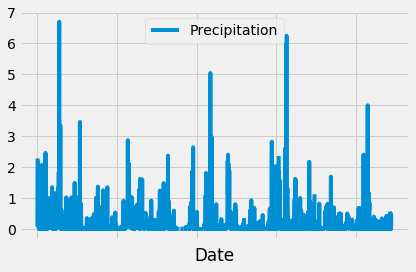

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12months = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date 1 year ago from the last data point in the database
yearago_data = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > yearago_data).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain)
rain_df.head()
# Sort the dataframe by date
rain_df.set_index('date').head()
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Images/precipitation.png")
plt.show()

![precipitation](Images/precipitation.png)

In [38]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [39]:
# Design a query to show how many stations are available in this dataset?
list_stations = session.query(Measurement).group_by(Measurement.station).count()
print(format(list_stations))

9


In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
list_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()
list_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [41]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperature = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == list_stations[0][0]).all()
print(f" {temperature[0][0]} , {temperature[0][1]} , {round(temperature[0][2], 1)}")

 54.0 , 85.0 , 71.7


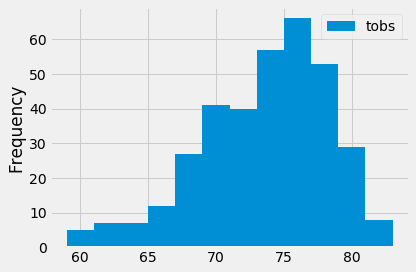

In [42]:
# Choose the station with the highest number of temperature observations.
temp_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
temp_stations= temp_stations[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observations = session.query( Measurement.tobs).filter(Measurement.date >= yearago_data).filter(Measurement.station == temp_stations).all()
temp_observations = pd.DataFrame(temp_observations, columns=['tobs'])
temp_observations.plot.hist(bins=12)
plt.tight_layout()
plt.savefig("Images/station-histogram.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [43]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [51]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same date
start_date = dt.date(2017, 1, 1)
end_date = dt.date(2017, 1, 14)
yearago = dt.timedelta(days=365)
temps_lists = (calc_temps((start_date-yearago), (end_date-yearago)))
print(temps_lists)

[(62.0, 69.81927710843374, 78.0)]


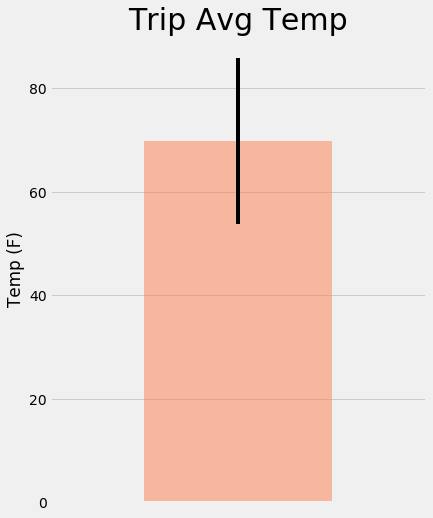

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps_lists_df = pd.DataFrame(temps_lists, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_temps_lists_df['Avg Temp']
min_max_temp = trip_temps_lists_df.iloc[0]['Max Temp'] - trip_temps_lists_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=30)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.savefig("Images/temperature.png")
plt.show()

In [46]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    percip = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*percip).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-07-01','2017-07-7'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.1), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.08), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.06), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, None)]


## Optional Challenge Assignment

In [47]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_norm(date):
    percip = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*percip).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_norm("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [48]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-01-01'
end_date ='2017-01-7'
# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()
trip_dates = [x[0] for x in dates]
# Stip off the year and save a list of %m-%d strings with another list comprehension 
trip_dates_stripped= [x[5:] for x in trip_dates]

# Find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

normals = normals[0]
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0),
 (56.0, 69.31372549019608, 78.0),
 (54.0, 68.62962962962963, 80.0),
 (61.0, 69.07407407407408, 76.0),
 (57.0, 68.63157894736842, 77.0),
 (60.0, 68.26315789473684, 78.0),
 (61.0, 68.86666666666666, 78.0),
 (61.0, 70.14545454545454, 76.0),
 (60.0, 69.26415094339623, 76.0),
 (57.0, 69.50909090909092, 79.0),
 (58.0, 68.76271186440678, 78.0),
 (61.0, 67.94915254237289, 75.0),
 (61.0, 70.58620689655173, 77.0),
 (59.0, 68.56896551724138, 75.0),
 (62.0, 69.03703703703704, 77.0),
 (64.0, 69.14, 76.0),
 (60.0, 67.12962962962963, 77.0),
 (60.0, 6

In [49]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df= pd.DataFrame(normals,columns=['tmin', 'tavg', 'tmax'])
normals_df['date']= trip_dates
normals_df['date'] = pd.to_datetime(normals_df['date'], format='%Y-%m-%d')

# Set index to date
normals_df.set_index('date',inplace=True)

normals_df.head()

,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0


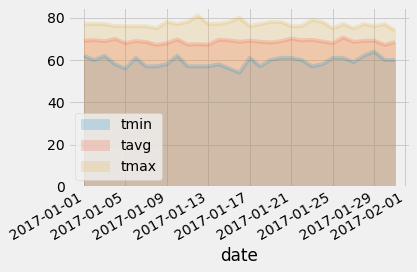

In [50]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True)
plt.tight_layout()
plt.savefig("Images/normals.png")
plt.show()